In [1]:
import pandas as pd

## Data Preparation

In [2]:
#load data
df_seq=pd.read_csv('pdb_data_seq.csv')
df_properties=pd.read_csv('pdb_data_no_dups.csv')
df_total=df_seq.merge(df_properties,left_on='structureId',right_on = 'structureId')


In [3]:
df_total.columns

Index(['structureId', 'chainId', 'sequence', 'residueCount_x',
       'macromoleculeType_x', 'classification', 'experimentalTechnique',
       'macromoleculeType_y', 'residueCount_y', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

#### Select only protein, and filtered by top N

In [4]:
#select the data in top n by count, top 10?
df_total=df_total[df_total['macromoleculeType_x'].isin(set(['Protein']))]

count = df_total['classification'].value_counts(dropna=False)[:10]
df_selected=df_total[df_total['classification'].isin(set(count.index))]
#we want only protein
#count = df_selected['classification'].value_counts(dropna=True)[:10]

In [5]:
count

HYDROLASE                        46336
TRANSFERASE                      36424
OXIDOREDUCTASE                   34322
IMMUNE SYSTEM                    15615
LYASE                            11682
HYDROLASE/HYDROLASE INHIBITOR    11218
TRANSCRIPTION                     8919
VIRAL PROTEIN                     8495
TRANSPORT PROTEIN                 8371
VIRUS                             6972
Name: classification, dtype: int64

#### Select proteins with only one chain

In [6]:
#select proteins with only one chain in the data set
#how to justify this operation?
#df_onechain = df_selected[df_selected.groupby('structureId').structureId.transform(len) == 1]

In [7]:
test_df = df_selected[['structureId','classification','sequence']]
#test_df = df_onechain[['structureId','classification','sequence']]

Things to be done

Further select data and simplify problem, select proteins with only one chain?


Figure out how to convert sequence data into array and training model afterwards. (22 - n -n)


More models and discussion (*LSTM)

Models build on features other than sequence.



## Data balancing

In [8]:
from sklearn.utils import resample
#upsample the minorities and then take 50000 sample from all

df_majority = test_df[test_df['classification']=='HYDROLASE']
df_minority = test_df[test_df['classification']=='HYDROLASE']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=46336,    # to match majority class
                                 random_state=123) # reproducible results
keylist = list(count.index)
datalist = [0]*9
for i in range(1,10):
    df_minority = test_df[test_df['classification']==keylist[i]]
    datalist[i-1] = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=46336,    # to match majority class
                                 random_state=123) # reproducible results
    #print(len(df_majority))
    df_majority = pd.concat([df_majority, datalist[i-1]])
data = df_majority.sample(50000)
    

## Model Training

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier

In [10]:
#optional, take part of the data for faster verification
#data = test_df#.sample(50000)

#need to remove nulls
data = data.dropna()
X_train, X_test,y_train,y_test = \
train_test_split(data['sequence'], data['classification'], test_size = 0.1, random_state = 1)

In [11]:
test_count = data['classification'].value_counts(dropna=False)[:10]

In [13]:
import numpy as np
np.asarray(test_count.index)

array(['TRANSCRIPTION', 'HYDROLASE', 'VIRUS', 'TRANSFERASE',
       'OXIDOREDUCTASE', 'VIRAL PROTEIN', 'HYDROLASE/HYDROLASE INHIBITOR',
       'TRANSPORT PROTEIN', 'IMMUNE SYSTEM', 'LYASE'], dtype=object)

#### Feature Extraction From Sequence Data

In [ ]:
"""
#vectorize data, prepare for building models
#Convert a collection of text documents to a matrix of token counts
#seems has nothing to do with sequence but only with the frequency

#ngram is a parameter we need to focus on, 

vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (1,1))
#vect = CountVectorizer(analyzer = 'char_wb')

# Fit and Transform CountVectorizer
#occasionally may meet np.nan error
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#to store the results for different mothods
prediction = dict()
"""

Iterate through models

In [14]:
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,recall_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.neural_network import MLPClassifier
import time

In [15]:
models = [MultinomialNB(),AdaBoostClassifier(),RandomForestClassifier(),KNeighborsClassifier(),DecisionTreeClassifier(),ExtraTreesClassifier()]

model_names=['NB','adaboost','randomForest','Kneighbors','DecisionTree','ExtraTree']
extra_models = dict(zip(model_names,models))

In [17]:
precisions={}
recalls={}
confusion_matrixs={}
types  = np.asarray(test_count.index)
score_table = {}
from tqdm import tqdm
init_time = time.time()
for i in tqdm(range(1,6)):
    #featrue extraction by count vectorization
    vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (i,i))
    vect.fit(X_train)
    X_train_df = vect.transform(X_train)
    X_test_df = vect.transform(X_test)
    for key in extra_models.keys():
        model = extra_models[key]
        model.fit(X_train_df,y_train)
        ADA_pred = model.predict(X_test_df)
        if key not in precisions:
            precisions[key] = [accuracy_score(ADA_pred , y_test)]
            #recalls[key] = [recall_score(ADA_pred , y_test)]
            confusion_matrixs[key] = [confusion_matrix(ADA_pred, y_test, labels = types)]
            score_table[key] = [classification_report(ADA_pred,y_test, labels = types)]
        else:
            precisions[key].append(accuracy_score(ADA_pred , y_test))  
            #recalls[key].append(recall_score(ADA_pred, y_test))
            confusion_matrixs[key].append(confusion_matrix(ADA_pred,y_test, labels = types))
            score_table[key].append( classification_report(ADA_pred,y_test, labels = types))
        print('time elapsed:',time.time()-init_time)
        print(i,key,accuracy_score(ADA_pred , y_test))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

time elapsed: 6.313120126724243
1 NB 0.3658
time elapsed: 11.458333015441895
1 adaboost 0.3924


D:\Users\ericl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time elapsed: 16.65446448326111
1 randomForest 0.8854
time elapsed: 28.524717807769775
1 Kneighbors 0.81
time elapsed: 31.427981853485107
1 DecisionTree 0.8648


D:\Users\ericl\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time elapsed: 38.38540840148926
1 ExtraTree 0.8888


 20%|████████████████▊                                                                   | 1/5 [00:38<02:33, 38.39s/it]

time elapsed: 49.086987257003784
2 NB 0.4836
time elapsed: 65.35645484924316
2 adaboost 0.3696
time elapsed: 87.70967698097229
2 randomForest 0.8874
time elapsed: 125.45630884170532
2 Kneighbors 0.8078
time elapsed: 161.67548298835754
2 DecisionTree 0.8676
time elapsed: 191.01701855659485
2 ExtraTree 0.883


 40%|█████████████████████████████████▌                                                  | 2/5 [03:11<03:37, 72.66s/it]

time elapsed: 204.50295877456665
3 NB 0.649
time elapsed: 231.9635202884674
3 adaboost 0.3288
time elapsed: 281.07219314575195
3 randomForest 0.8836
time elapsed: 300.04744935035706
3 Kneighbors 0.7464
time elapsed: 405.6808133125305
3 DecisionTree 0.869
time elapsed: 467.06266379356384
3 ExtraTree 0.8834


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:47<04:27, 133.68s/it]

time elapsed: 483.68521213531494
4 NB 0.8334
time elapsed: 520.5418469905853
4 adaboost 0.3586
time elapsed: 654.9119713306427
4 randomForest 0.887
time elapsed: 663.5891852378845
4 Kneighbors 0.741
time elapsed: 833.1572961807251
4 DecisionTree 0.8726
time elapsed: 1007.2229106426239
4 ExtraTree 0.8962


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [16:47<04:15, 255.62s/it]

time elapsed: 1033.8369362354279
5 NB 0.892


D:\Users\ericl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


time elapsed: 1116.0102186203003
5 adaboost 0.35
time elapsed: 1735.4847722053528
5 randomForest 0.8876
time elapsed: 1742.2905447483063
5 Kneighbors 0.7348
time elapsed: 2697.8521745204926
5 DecisionTree 0.8834
time elapsed: 3628.7928302288055
5 ExtraTree 0.896


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:00:28<00:00, 965.41s/it]


In [18]:
precisions

{'NB': [0.3658, 0.4836, 0.649, 0.8334, 0.892],
 'adaboost': [0.3924, 0.3696, 0.3288, 0.3586, 0.35],
 'randomForest': [0.8854, 0.8874, 0.8836, 0.887, 0.8876],
 'Kneighbors': [0.81, 0.8078, 0.7464, 0.741, 0.7348],
 'DecisionTree': [0.8648, 0.8676, 0.869, 0.8726, 0.8834],
 'ExtraTree': [0.8888, 0.883, 0.8834, 0.8962, 0.896]}

In [20]:
import matplotlib.pyplot as plt

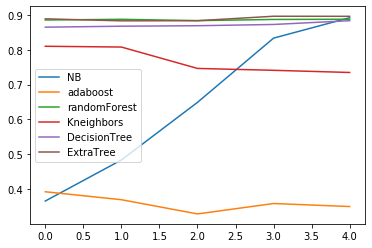

In [22]:
for key in precisions.keys():
    plt.plot(precisions[key],label = key)
plt.legend()
plt.show()


In [28]:
import seaborn as sns

In [39]:
sns.heatmap?

In [37]:
names = list(test_count.index)

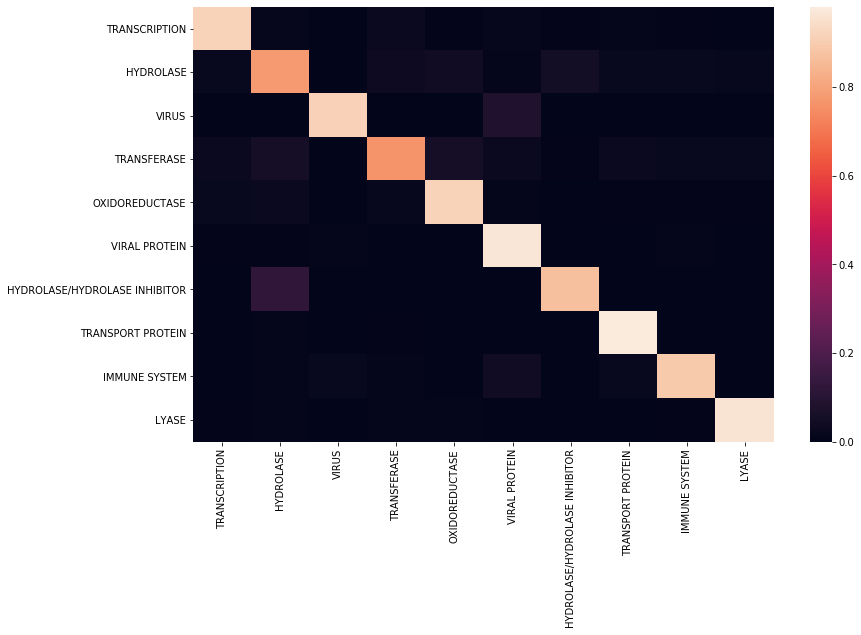

In [38]:

# Plot confusion matrix
conf_mat = confusion_matrixs['NB'][4]

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
ax = plt.axes()
sns.heatmap(conf_mat,xticklabels = names, yticklabels = names,ax = ax)
ax.set_title('Confusion matrix for Naive Bye')
